In [231]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


# Get Data

In [232]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
# get higher scores if i use this, but shouldnt as too correlated
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

No need to standardise as not sensitive to magnitude. So we can now split into test and train sets

In [233]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label)

# Create & Train Model

In [234]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print('Confusion matrix\n\n', cm)

print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.96      0.96      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

Confusion matrix

 [[88  2]
 [ 2 51]]
0.972027972027972


From the confusion matrix we can see only 4 incorrect guesses (2 FP and 2 FN).

In [235]:
# We use this instead to determine the most important features
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)



Concavity                0.289313
RadiusWorst              0.283695
ConcavePointsWorst       0.096420
Compactness              0.086019
ConcavePoints            0.045268
RadiusSE                 0.020623
ConcavityWorst           0.017307
FractalDimensionSE       0.016999
SymmetryWorst            0.015741
CompactnessWorst         0.014930
TextureWorst             0.013352
FractalDimension         0.013140
Texture                  0.011357
Radius                   0.010004
Smoothness               0.009924
ConcavePointsSE          0.009587
SymmetrySE               0.007856
ConcavitySE              0.007425
FractalDimensionWorst    0.007263
SmoothnessSE             0.006901
CompactnessSE            0.006299
SmoothnessWorst          0.005619
TextureSE                0.003019
Symmetry                 0.001940
dtype: float64


In [236]:
# trying it again with different columns
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print(accuracy_score(y_test, y_pred))
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(confusion_matrix(y_test, y_pred))



0.965034965034965
[[88  2]
 [ 3 50]]


# Hyperparameter Tuning

In [237]:
n_estimators = [int(x) for x in range(0,100,1)]
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)
max_features = ['sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [238]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
best_random = rf_random.best_estimator_
y_pred = best_random.predict(x_test)
print(rf_random.best_estimator_)
print(metrics.accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=84; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=63; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=63; total time=   0.1s
[CV] END bootstrap=True, max_depth=108, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=108, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=68; total time=   0.1s
[CV] END bootstrap=False, max_depth=108, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=68; 

# Test for over/ underfitting



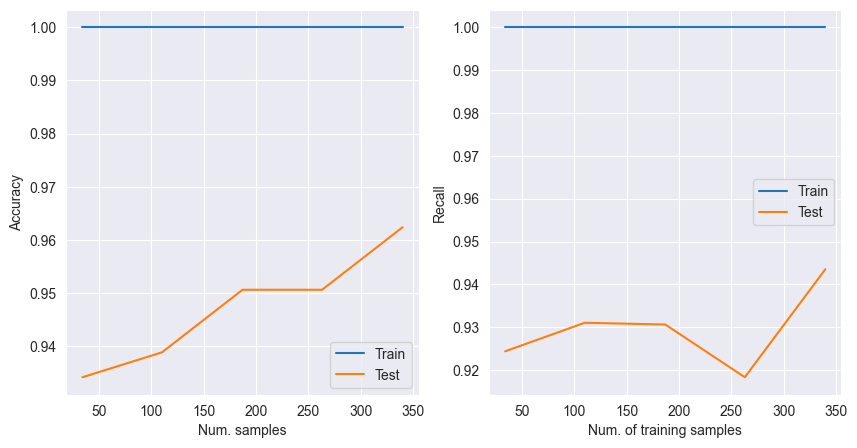

In [239]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=best_random, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=best_random, X=x_train, y=LabelEncoder().fit_transform(y_train), scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Array of tuples (train_size, train_score)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

100% accuracy and not changing with the number of samples is clearly overfitting, so we will manually remove the least significant variables we calculated to simplify our model- so that we can make up for our lack of instances.